In [1]:
pip install pandas geojson folium matplotlib shapely geopandas contextily

Note: you may need to restart the kernel to use updated packages.


# Data Extraction

In [2]:
import os

print(os.listdir(os.getcwd()))

['explore_poi.ipynb', 'road_highlight_map.html', 'road_path_map.html', 'singapore_hawkers_map.html']


In [3]:
import os
# Move up to the parent folder
current_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(current_dir, "data", "singapore\\")
print(data_dir)

gym_file = data_dir + "GymsSGGEOJSON_202501.geojson"
hawker_file = data_dir + "HawkerCentresKML_202501.kml"
hdb_file = data_dir + "HDBExistingBuilding_202501.geojson"
master_land_file = data_dir + "MasterPlan2019LandUselayer_202501.geojson"
master_plan_file = data_dir + "MasterPlan2019PlanningAreaBoundaryNoSea_202501.geojson"
map_polygon_file = data_dir + "NationalMapPolygon_202501.kml"
park_file = data_dir + "ParkFacilities_202501.geojson"
preschool_file = data_dir + "PreSchoolsLocation_202501.geojson"
road_file = data_dir + "RoadNetwork_202501.kml"
tourist_file = data_dir + "TouristAttractions_202501.geojson"

c:\Users\meiro\Documents\1_project\trade-area-analysis\data\singapore\


### Common Utilities

In [4]:
import pandas as pd

def visualize_data(data_path):
    # Read data
    df = pd.read_csv(data_path, header=0)
    # Clean data 
    df.columns = df.columns.str.lower()

    print(f"there are {len(df)} rows of data")

    display(df.head(5))

    return df

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Enable inline plotting in Jupyter
%matplotlib inline

def visualize_pois(df, plot_title):
    # Create a GeoDataFrame from the pandas DataFrame
    # Convert lat, lon into Point geometries for the hawker centers
    geometry = [Point(lon, lat) for lon, lat in zip(df["lon"], df["lat"])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)

    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857 (Web Mercator)
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    gdf = gdf.to_crs(epsg=3857)

    # Plotting the map with contextily basemap
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color="red", marker="o", markersize=50, label=plot_title)

    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Customize the map
    ax.set_title(f"{plot_title} in Singapore", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend()

    plt.show()

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString

# Enable inline plotting in Jupyter
%matplotlib inline

# Function to parse the coordinates into a LineString
def visualize_lines(df, plot_title):
    # Convert coordinates to Shapely LineString geometries
    df["geometry"] = df["coordinates"]

    # Create a GeoDataFrame from the pandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry="geometry")

    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    gdf = gdf.to_crs(epsg=3857)

    # Plotting the map with contextily basemap
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the roads
    gdf.plot(ax=ax, color="red", linewidth=2, label=plot_title)

    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Customize the map
    ax.set_title(f"{plot_title} in Singapore", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend()

    plt.show()

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon

def visualize_polygons(df, plot_title):
    # Convert the Coordinates column to Shapely Polygon objects
    # polygons = []
    # for index, row in df.iterrows():
    #     coordinates = row["coordinates"]
    #     print(coordinates)
    #     polygons.append(Polygon(coordinates))
    df["geometry"] = df["coordinates"].apply(Polygon)

    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    
    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857 (Web Mercator)
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    gdf = gdf.to_crs(epsg=3857)

    # Plot the polygons
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.7)

    # Add labels at the centroid of each polygon
    for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf["polygon_name"]):
        ax.text(x, y, label, fontsize=8, ha="center", color="red")
    
    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Set the title and show the plot
    ax.set_title(f"{plot_title} in Singapore", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend()
    
    plt.show()

### Extract tourist attraction

In [8]:
import re
import json
import csv

# Function to extract specific field using split
def extract_field(description, field_name):
    try:
        return description.split(f"<th>{field_name}</th> <td>")[1].split("</td>")[0].strip()
    except IndexError:
        return f"{field_name} not found"


with open(tourist_file) as f:
    geojson_data = json.load(f)

# Prepare the CSV data
csv_data = []

# Extract data from each feature
for feature in geojson_data["features"]:
    # Accessing the properties dictionary
    description = feature["properties"]["Description"]

    # Extract desired fields
    fields_to_extract = [
        "IMAGE_PATH",
        "OVERVIEW",
        "PAGETITLE",
        "LATITUDE",
        "LONGTITUDE",
        "ADDRESS",
        "POSTALCODE"
    ]

    extracted_fields = {}
    for field in fields_to_extract:
        extracted_fields[field] = extract_field(description, field)
    
    extracted_fields["name"] = feature["properties"]["Name"]
    extracted_fields["type"] = feature["geometry"]["type"]
    extracted_fields["coordinates"] = feature["geometry"]["coordinates"]
    # extracted_fields["lat"] = feature["geometry"]["coordinates"][1]
    # extracted_fields["lon"] = feature["geometry"]["coordinates"][0]

    csv_data.append(extracted_fields)
    
# Write extracted data to CSV
csv_columns = set().union(*(d.keys() for d in csv_data))
tourist_csv = data_dir + "tourist_spot_202501.csv"
with open(tourist_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(csv_data)

print("data extracted to data folder")

data extracted to data folder


In [9]:
df_tourist = visualize_data(tourist_csv)
df_tourist["lon"] = df_tourist["longtitude"]
df_tourist["lat"] = df_tourist["latitude"]

there are 109 rows of data


,address,pagetitle,longtitude,latitude,coordinates,image_path,type,overview,name,postalcode
0,1 St Andrew's Road,National Gallery Singapore,103.851356,1.290,"[103.851355999735, 1.29000000002855, 0.0]",www.yoursingapore.com/content/dam/desktop/glob...,Point,Take in the regionÃ¢â‚¬â„¢s newest and largest...,kml_1,NaN
1,3 Muscat Street,Sultan Mosque (Masjid Sultan) Singapore,103.859171,1.302,"[103.859171000287, 1.3020000004261, 0.0]",NaN,Point,"Also known as Masjid Sultan, the impressive Su...",kml_2,NaN
2,244 South Bridge Road,Sri Mariamman Temple: Hindu Temple in Singapore,103.845380,1.282,"[103.845380000189, 1.28200000029374, 0.0]",www.yoursingapore.com/content/dam/desktop/glob...,Point,"Located in Chinatown, the Sri Mariamman Temple...",kml_3,NaN
3,60 Hill Street,Armenian Church in Singapore,103.849660,1.293,"[103.849660000324, 1.29300000039531, 0.0]",www.yoursingapore.com/content/dam/desktop/glob...,Point,The oldest Christian church in Singapore is an...,kml_4,NaN
4,30 Victoria Street,CHIJMES Singapore,103.851680,1.295,"[103.851680000243, 1.29500000011955, 0.0]",www.yoursingapore.com/content/dam/desktop/glob...,Point,Whether functioning as a school or a lifestyle...,kml_5,NaN


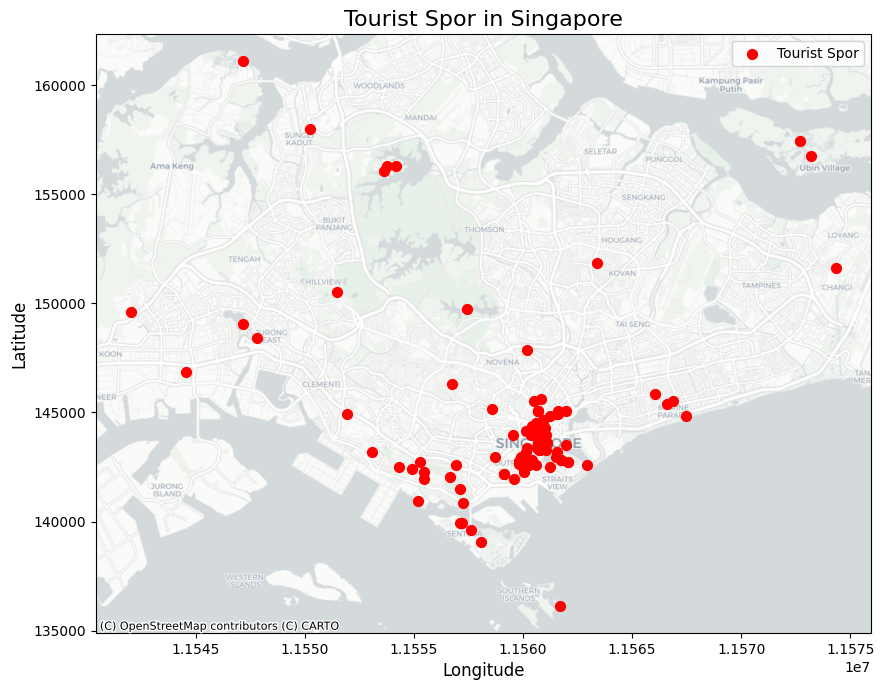

In [10]:
visualize_pois(df_tourist, "Tourist Attractions")

### Extract HDB data 

In [11]:
import re
import json
import csv

with open(hdb_file) as f:
    geojson_data = json.load(f)

# Extract column names dynamically from the Description field
# description_sample = geojson_data["features"][0]["properties"]["Description"]
# columns = re.findall(r"<th>(.*?)<\/th>", description_sample)

# Prepare the CSV data
csv_data = []
for feature in geojson_data["features"]:
    # Extract properties
    name = feature["properties"]["Name"]
    description = feature["properties"]["Description"]
    
    # Extract individual attributes from the description HTML
    blk_no = description.split("<th>BLK_NO</th> <td>")[1].split("</td>")[0]
    st_cod = description.split("<th>ST_COD</th> <td>")[1].split("</td>")[0]
    entityid = description.split("<th>ENTITYID</th> <td>")[1].split("</td>")[0]
    postal_cod = description.split("<th>POSTAL_COD</th> <td>")[1].split("</td>")[0]
    inc_crc = description.split("<th>INC_CRC</th> <td>")[1].split("</td>")[0]
    fmel_upd_d = description.split("<th>FMEL_UPD_D</th> <td>")[1].split("</td>")[0]
    
    # Extract geometry
    geometry_type = feature["geometry"]["type"]
    coordinates = feature["geometry"]["coordinates"]
    
    # Append parsed data
    csv_data.append({
        "name": name,
        "block_no": blk_no,
        "street_code": st_cod,
        "entity_id": entityid,
        "postal_code": postal_cod,
        "incremental_checksum": inc_crc,
        "first_merge_last_update_date": fmel_upd_d,
        "geometry_type": geometry_type,
        "coordinates": coordinates,
    })


# Write extracted data to CSV
csv_columns = set().union(*(d.keys() for d in csv_data))
hdb_csv = data_dir + "hdb_202501.csv"
with open(hdb_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(csv_data)

print("data extracted to data folder")

data extracted to data folder


In [12]:
import ast

# Function to remove the altitude (third element) from each coordinate
def sanitize_coordinates(coords):
    coords = coords[0]  # Flatten the list 
    return [coord[:2] for coord in coords]

df_hdb = visualize_data(hdb_csv)
df_hdb["polygon_name"] = df_hdb["block_no"]
# Convert string to list
df_hdb['coordinates'] = df_hdb['coordinates'].apply(ast.literal_eval)
# Function to remove the altitude (third element) from each coordinate
df_hdb['coordinates'] = df_hdb['coordinates'].apply(sanitize_coordinates)
print("--------------")
display(df_hdb.head(5))

there are 12847 rows of data


,entity_id,block_no,first_merge_last_update_date,coordinates,postal_code,geometry_type,street_code,name,incremental_checksum
0,1991,780C,20230328181025,"[[[103.801697204792, 1.44919018597124, 0.0], [...",733780,Polygon,WOC05L,kml_1,B93627FDFF3D6313
1,6782,373,20130426120311,"[[[103.750230078901, 1.3589707561372, 0.0], [1...",650373,Polygon,BUS09S,kml_2,49487496978A23EF
2,7578,328,20130426120323,"[[[103.958111068021, 1.35343755833904, 0.0], [...",520328,Polygon,TAS39U,kml_3,67E2089D8D4D20D0
3,307,771A,20130426120328,"[[[103.749716688233, 1.39435458145642, 0.0], [...",681771,Polygon,CHS27B,kml_4,577EE045DEA00FEE
4,7332,3A,20130426120321,"[[[103.817313472832, 1.27886768972495, 0.0], [...",91003,Polygon,TEC01D,kml_5,AF8FF795FF2C87EA


--------------


,entity_id,block_no,first_merge_last_update_date,coordinates,postal_code,geometry_type,street_code,name,incremental_checksum,polygon_name
0,1991,780C,20230328181025,"[[103.801697204792, 1.44919018597124], [103.80...",733780,Polygon,WOC05L,kml_1,B93627FDFF3D6313,780C
1,6782,373,20130426120311,"[[103.750230078901, 1.3589707561372], [103.750...",650373,Polygon,BUS09S,kml_2,49487496978A23EF,373
2,7578,328,20130426120323,"[[103.958111068021, 1.35343755833904], [103.95...",520328,Polygon,TAS39U,kml_3,67E2089D8D4D20D0,328
3,307,771A,20130426120328,"[[103.749716688233, 1.39435458145642], [103.74...",681771,Polygon,CHS27B,kml_4,577EE045DEA00FEE,771A
4,7332,3A,20130426120321,"[[103.817313472832, 1.27886768972495], [103.81...",91003,Polygon,TEC01D,kml_5,AF8FF795FF2C87EA,3A


C:\Users\meiro\AppData\Local\Temp\ipykernel_11712\3171777949.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["geometry"] = df["coordinates"].apply(Polygon)
c:\Users\meiro\Documents\1_project\trade-area-analysis\.venv\lib\site-packages\contextily\tile.py:645: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)
C:\Users\meiro\AppData\Local\Temp\ipykernel_11712\3171777949.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


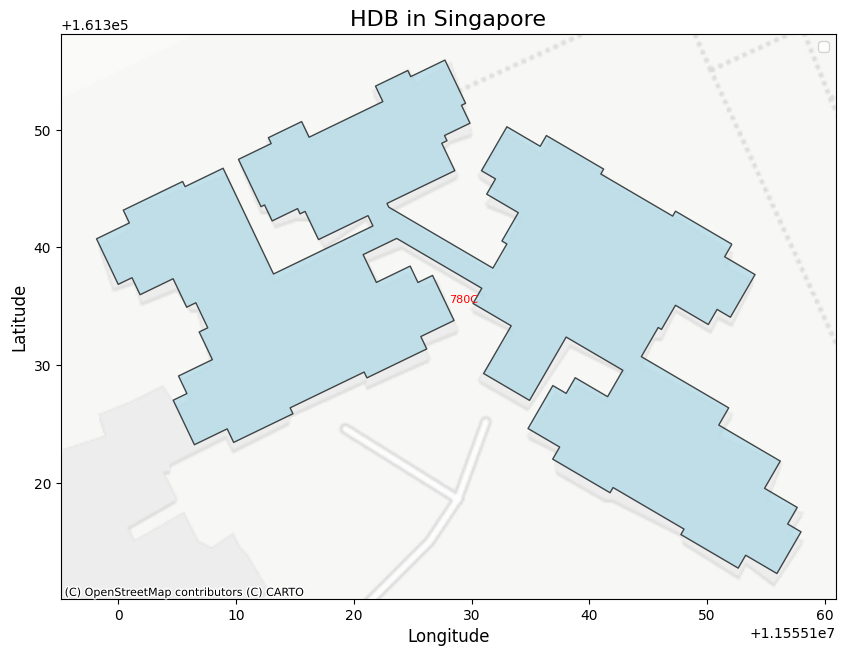

In [13]:
visualize_polygons(df_hdb[:1], 'HDB')

### Extract gym data

In [14]:
import re
import json
import csv

with open(gym_file) as f:
    geojson_data = json.load(f)

# Extract column names dynamically from the Description field
description_sample = geojson_data["features"][0]["properties"]["Description"]
columns = re.findall(r"<th>(.*?)<\/th>", description_sample)

# Prepare the CSV data
csv_data = []
for feature in geojson_data["features"]:
    properties = feature["properties"]
    description = properties["Description"]
    
    # Extract values dynamically for each column
    values = re.findall(r"<td>(.*?)<\/td>", description)
    row = dict(zip(columns, values))
    
    # Add geometry coordinates
    row["lon"] = feature["geometry"]["coordinates"][0]
    row["lat"] = feature["geometry"]["coordinates"][1]
    csv_data.append(row)

# Write to a CSV file
gym_csv = data_dir + "gym_202501.csv"
with open(gym_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=columns + ["lon", "lat"])
    writer.writeheader()
    writer.writerows(csv_data)

print(f"data extracted to data folder")

data extracted to data folder


In [15]:
df_gym = visualize_data(gym_csv)

there are 159 rows of data


,landyaddresspoint,landxaddresspoint,addresspostalcode,addressbuildingname,hyperlink,photourl,addressunitnumber,addressfloornumber,addressstreetname,addressblockhousenumber,description,inc_crc,fmel_upd_d,name,lon,lat
0,0,0,78989,NaN,NaN,NaN,NaN,NaN,Tras Street,50,Operating Hours: 7.00am - 10.00am,0E28997B4498C8C3,20160127095840,The Pit,103.844202,1.278114
1,0,0,287992,House J and S,NaN,NaN,NaN,NaN,Turf Club Road,100,"Operating Hours: Monday, Wednesday, Friday: 1...",CAA5268B7BA8784D,20160127095840,The Stable Mixed Martial Arts,103.795898,1.334220
2,0,0,579783,NaN,NaN,NaN,NaN,NaN,Bishan St. 4,5,Facilities: Standard Gymnasium Equipment Opera...,E7A4A38558FA4D85,20160127095840,Bishan ClubFITT Gym,103.850922,1.355283
3,0,0,208568,King George's Building,NaN,NaN,NaN,NaN,King George's Ave,328,NaN,CBB24D03E2FE458E,20160127095840,The Yoga Place,103.862091,1.309922
4,0,0,559022,NaN,NaN,NaN,10,1,Bughley Drive Blk B,45,NaN,51E0C317DBD72838,20160127095840,Sky Fitness - Serangoon Gardens,103.859571,1.360010


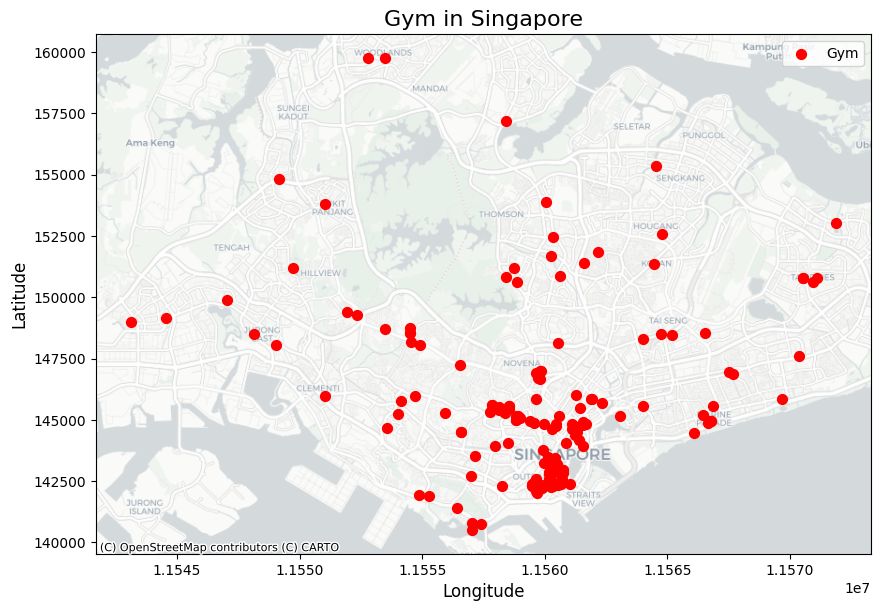

In [16]:
visualize_pois(df_gym, 'Gym')

### Extract hawker centre

In [17]:
# Convert kml file to csv
import xml.etree.ElementTree as ET
import csv

# Parse the KML file
tree = ET.parse(hawker_file)  # Replace with your KML file path
root = tree.getroot()

# Namespace mapping
ns = {
    "kml": "http://www.opengis.net/kml/2.2",
    "gx": "http://www.google.com/kml/ext/2.2",
}

# Extract Placemark data
hawker_data = []
for placemark in root.findall(".//kml:Placemark", ns):
    data = {}
    for simple_data in placemark.findall(".//kml:SimpleData", ns):
        key = simple_data.attrib["name"]
        value = simple_data.text
        data[key] = value
    coordinates = placemark.find(".//kml:coordinates", ns)
    if coordinates is not None:
        data["coordinates"] = coordinates.text.strip()
    hawker_data.append(data)

# Write data to CSV
csv_columns = set().union(*(d.keys() for d in hawker_data))
hawker_csv = data_dir + "hawker_centre_202501.csv"
with open(hawker_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(hawker_data)

print("data extracted to data folder")

data extracted to data folder


In [18]:
df_hawker = visualize_data(hawker_csv)

there are 125 rows of data


,est_original_completion_date,coordinates,approximate_gfa,fmel_upd_d,address_myenv,addressstreetname,addresspostalcode,description,addressbuildingname,addressblockhousenumber,awarded_date,inc_crc,photourl,name,info_on_co_locators,hup_completion_date,status,landyaddresspoint,landxaddresspoint,implementation_date
0,15/11/2021,"103.850164578087,1.2844248503218,0.0",NaN,20221017143612,NaN,Market Street,48940.0,New Replacement Centre,CapitaSpring,50,17/7/2017,DB83871D0E006559,NaN,Market Street Hawker Centre,hawker centre/commercial space,NaN,Existing (replacement),29650.70,29874.82,1/8/2017
1,8/11/2017,"103.779784899996,1.43353885680037,0.0",3661.0,20221017143612,"Blk 4,Woodlands St 12,Singapore�738623",Woodlands Street 12,738623.0,New Replacement Centre,Marsiling Mall,4,4/9/2015,67D9A36B865FC1FB,http://www.nea.gov.sg/images/default-source/Ha...,Marsiling Mall Hawker Centre,hawker centre/supermarket/shops,NaN,Existing (replacement),46139.03,22042.51,1/1/2016
2,30/3/2022,"103.804715225285,1.29748567106686,0.0",NaN,20221017143612,NaN,Margaret Drive,142038.0,New Replacement Centre,NaN,38A,11/5/2015,C80F89698B7A8757,NaN,Margaret Drive Hawker Centre,hawker centre/branch office/supermarket/shops/...,NaN,Existing (replacement),31094.91,24816.70,2/12/2015
3,22/3/2022,"103.877060478847,1.39159232727757,0.0",NaN,20221017143612,NaN,Sengkang West Avenue,797650.0,New Centre,"Fernvale Community Club, Hawker Centre & Market",21,30/7/2018,E3AB7D1743979E42,NaN,Fernvale Hawker Centre & Market,hawker centre/market/community club,NaN,Existing (new),41500.77,32867.90,13/8/2018
4,29/4/2022,"103.904805657576,1.40818996870647,0.0",NaN,20221017143612,NaN,Punggol Drive,828629.0,New Centre,One Punggol,1,8/8/2018,4780858D968F79C9,NaN,One Punggol Hawker Centre,hawker centre/Regional Library/Senior Care Cen...,NaN,Existing (new),43336.13,35955.52,29/8/2018


In [19]:
# Split the "coordinates" column into "lon", "lat", and "alt", allowing for incomplete splits
df_hawker[["lon", "lat", "alt"]] = df_hawker["coordinates"].str.split(",", expand=True)

# Check if all columns are properly filled (handle missing values if needed)
df_hawker[["lon", "lat", "alt"]] = df_hawker[["lon", "lat", "alt"]].apply(pd.to_numeric, errors='coerce')

display(df_hawker.head(1))

,est_original_completion_date,coordinates,approximate_gfa,fmel_upd_d,address_myenv,addressstreetname,addresspostalcode,description,addressbuildingname,addressblockhousenumber,...,name,info_on_co_locators,hup_completion_date,status,landyaddresspoint,landxaddresspoint,implementation_date,lon,lat,alt
0,15/11/2021,"103.850164578087,1.2844248503218,0.0",NaN,20221017143612,NaN,Market Street,48940.0,New Replacement Centre,CapitaSpring,50,...,Market Street Hawker Centre,hawker centre/commercial space,NaN,Existing (replacement),29650.7,29874.82,1/8/2017,103.850165,1.284425,0.0


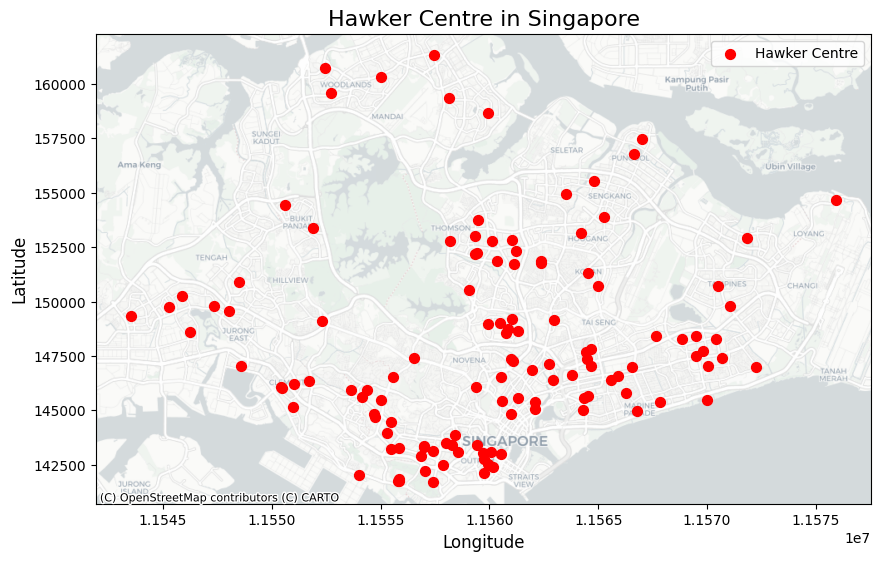

In [20]:
visualize_pois(df_hawker, "Hawker Centre")

In [21]:
import folium

# Sample hawker data with lat, lon (you can replace this with your actual dataset)
data = df_hawker [["name", "lat", "lon"]]
# Initialize the map centered at Singapore's location
singapore_map = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# Add markers for each hawker center
for idx, row in data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['name']
    ).add_to(singapore_map)

# Save the map to an HTML file
singapore_map.save("singapore_hawkers_map.html")

# Display map in a Jupyter notebook (if using Jupyter)
singapore_map


### Extract road network

In [22]:
# Convert kml file to csv
import xml.etree.ElementTree as ET
import csv

# Parse the KML file
tree = ET.parse(road_file)
root = tree.getroot()

# Namespace mapping
ns = {
    "kml": "http://www.opengis.net/kml/2.2",
    "gx": "http://www.google.com/kml/ext/2.2",
}

# Extract Placemark data for the road network
road_network_data = []
for placemark in root.findall(".//kml:Placemark", ns):
    road_name = placemark.find(".//{http://www.opengis.net/kml/2.2}SimpleData[@name='RD_NAME']").text
    road_type = placemark.find(".//{http://www.opengis.net/kml/2.2}SimpleData[@name='RD_TYP_CD']").text
    level_of_road = placemark.find(".//{http://www.opengis.net/kml/2.2}SimpleData[@name='LVL_OF_RD']").text
    coordinates = placemark.find(".//{http://www.opengis.net/kml/2.2}coordinates").text.strip()
    
    # Prepare the extracted data in a structured format
    road_network_data.append({
        'road_name': road_name,
        'road_type': road_type,
        'level_of_road': level_of_road,
        'coordinates': coordinates
    })

# Write extracted data to CSV
csv_columns = set().union(*(d.keys() for d in road_network_data))
road_csv = data_dir + "road_network_202501.csv"
with open(road_csv, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(road_network_data)

print("data extracted to data folder")

data extracted to data folder


In [23]:
df_rn = visualize_data(road_csv)

there are 61822 rows of data


,coordinates,level_of_road,road_type,road_name
0,"103.872264575107,1.39520697797869,0.0 103.8725...",At-grade,Slip Road,SENGKANG WEST WAY
1,"103.87288738574,1.39534787103477,0.0 103.87296...",At-grade,Imaginary Line,SENGKANG WEST WAY
2,"103.87225257993,1.39509535073548,0.0 103.87226...",At-grade,Imaginary Line,SENGKANG WEST WAY
3,"103.873705682171,1.39510194332845,0.0 103.8737...",At-grade,Local Access,LORONG TANGGAM
4,"103.873751233561,1.39524187566706,0.0 103.8737...",At-grade,Expunged,LORONG TANGGAM


In [24]:
def parse_coordinates(coord_string):
    coords = coord_string.split(' ')
    coordinates = [(float(coord.split(',')[0]), float(coord.split(',')[1])) for coord in coords]
    return LineString(coordinates)

df_rn["coordinates_old"] = df_rn["coordinates"]
df_rn["coordinates"] = df_rn["coordinates_old"].apply(parse_coordinates)
display(df_rn.head(1))

,coordinates,level_of_road,road_type,road_name,coordinates_old
0,"LINESTRING (103.872264575107 1.39520697797869,...",At-grade,Slip Road,SENGKANG WEST WAY,"103.872264575107,1.39520697797869,0.0 103.8725..."


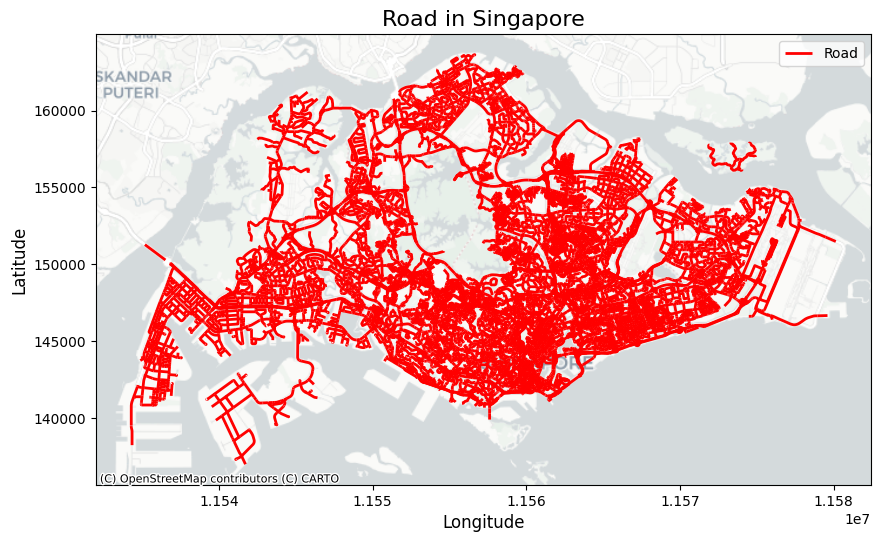

In [25]:
visualize_lines(df_rn, 'Road')